Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Fast Inference with MONAI Features

## Accelerating Model Inference with MONAI

In the rapidly evolving field of medical imaging, the ability to perform fast and efficient model inference is crucial for real-time diagnostics and treatment planning. This tutorial explores three advanced features of the MONAI framework that are designed to significantly accelerate model inference, particularly when leveraging the computational power of NVIDIA GPUs.

1. **TensorRT Inference**: Learn how to utilize NVIDIA's TensorRT to optimize and execute models for high-performance inference, reducing latency and improving throughput.

2. **GPU-Based Preprocessing**: Discover how to offload data preprocessing tasks to the GPU, minimizing CPU bottlenecks and accelerating the overall inference pipeline.

3. **Direct GPU Data Loading**: Understand the benefits of loading data directly from disk into GPU memory, which reduces data transfer times and enhances processing efficiency.

In addition to exploring these features, this tutorial provides a comprehensive benchmarking strategy to evaluate the performance improvements offered by each feature. We will use MONAI's [wholeBody_ct_segmentation](https://github.com/Project-MONAI/model-zoo/tree/dev/models/wholeBody_ct_segmentation) as a reference and build a Liver CT segmentation model for benchmarking purposes.

Finally, we will analyze and visualize the benchmark results, offering insights into the performance gains achieved through these optimizations. By the end of this tutorial, you will have a deeper understanding of how to leverage MONAI's capabilities to enhance the efficiency of your medical imaging workflows.

## Install environment

Loading data directly from disk to GPU memory requires the `kvikio` library. In addition, this tutorial requires many other dependencies such as `monai`, `torch`, `torch_tensorrt`, `numpy`, `ignite`, `pandas`, `matplotlib`, etc. We recommend using the [MONAI Docker](https://docs.monai.io/en/latest/installation.html#from-dockerhub) image to run this tutorial, which includes pre-configured dependencies and allows you to skip manual installation.

If not using MONAI Docker, install `kvikio` using one of these methods:

- **PyPI Installation**  
  Use the appropriate package for your CUDA version:
  ```bash
  pip install kvikio-cu12  # For CUDA 12
  pip install kvikio-cu11  # For CUDA 11
  ```

- **Conda/Mamba Installation**  
  Follow the official [KvikIO installation guide](https://docs.rapids.ai/api/kvikio/nightly/install/) for Conda/Mamba installations.

For convenience, we provide the cell below to install all the dependencies (please modify the cell based on your actual CUDA version, and please note that only CUDA 11 and CUDA 12 are supported for now).

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, pydicom, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import torch_tensorrt" || pip install torch_tensorrt
!python -c "import kvikio" || pip install kvikio-cu12
!python -c "import pandas" || pip install pandas
!python -c "import requests" || pip install requests
!python -c "import onnx" || pip install onnx
%matplotlib inline

## Setup imports

In [ ]:
import os

import torch
import torch_tensorrt
from monai.config import print_config
from monai.transforms import (
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    Orientationd,
    Spacingd,
    NormalizeIntensityd,
    ScaleIntensityd,
    Compose,
)
from monai.inferers import sliding_window_inference
from monai.networks.nets import SegResNet
import matplotlib.pyplot as plt
import torch
import gc
import pandas as pd
from timeit import default_timer as timer

print_config()

## Introduction on Fast Inference Features

### 1. TensorRT Inference

`monai.networks.utils.convert_to_trt` is a function that converts a PyTorch model to a TensorRT engine-based TorchScript model. Except the loading method (need to use `torch.jit.load` to load the model), the usage of the converted TorchScriptmodel is the same as the original model.

`monai.data.torchscript_utils.save_net_with_metadata` is a function that saves the converted TorchScript model and its metadata.

example:

```py

from monai.networks.nets import SegResNet
from monai.networks.utils import convert_to_trt
from monai.data.torchscript_utils import save_net_with_metadata

model = SegResNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=105,
    init_filters=32,
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    dropout_prob=0.2,
)
weights = torch.load("model.pt")
model.load_state_dict(weights)
torchscript_model = convert_to_trt(
    model=model,
    precision="fp16",
    input_shape=[1, 1, 96, 96, 96],
    dynamic_batchsize=[1, 4, 4],
    use_trace=True,
    verify=False,
)

save_net_with_metadata(torchscript_model, "segresnet_trt")

model = torch.jit.load("segresnet_trt.ts")
```

### 2. GPU-Based Preprocessing

`monai.transforms.EnsureTyped` transform allows you to specify the `device` and `dtype` for the output tensor. Therefore, in order to perform GPU-based preprocessing, you can insert the `EnsureTyped` transform at the beginning of your preprocessing transforms. For example:

```python
preprocess_transforms = [
    EnsureTyped(keys="image", device=torch.device("cuda:0"), track_meta=True),
    Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-57,
        a_max=164,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
]
```

### 3. Direct GPU Data Loading

Starting with MONAI `1.4.1rc1`, `monai.data.PydicomReader` and `monai.data.NibabelReader` added the `to_gpu` argument to enable direct GPU data loading. To use this feature, you can set the `to_gpu` argument to `True` when initializing the `LoadImaged` transform. For example:

```python
loader = LoadImaged(keys="image", reader="NibabelReader", to_gpu=True)
```

Please note that only NIfTI (.nii, for compressed ".nii.gz" files, this feature also supports but the acceleration is not significant) and DICOM (.dcm) files are supported for direct GPU data loading.


## Benchmarking Strategy

In this section, we will benchmark the acceleration performance on each feature. Specifically, we will benchmark the following inference workflows:

- Original inference workflow
- TensorRT inference workflow
- TensorRT inference workflow with GPU-based preprocessing
- TensorRT inference workflow with direct GPU data loading and GPU-based preprocessing

For each benchmark type, `timeit.default_timer` is used to measure the time taken.

### Define Benchmark Type

A variable `benchmark_type` is used to specify the type of benchmark to run. To have a fair comparison, each benchmark type should be run after restarting the notebook kernel. `benchmark_type` can be one of the following:

- `"original"`: benchmark the original model inference.
- `"trt"`: benchmark the TensorRT accelerated model inference.
- `"trt_gpu_transforms"`: benchmark the model inference with GPU transforms.
- `"trt_gds_gpu_transforms"`: benchmark the model inference with GPU data loading and GPU transforms.

In [3]:
# please uncomment the expected benchmark type to run

benchmark_type = "original"
# benchmark_type = "trt"
# benchmark_type = "trt_gpu_transforms"
# benchmark_type = "trt_gds_gpu_transforms"

### Prepare Data and Model

The [Medical Segmentation Decathlon Task03 Liver dataset](http://medicaldecathlon.com/) is used as an example to benchmark the acceleration performance.

A helper script, [`prepare_data.py`](./prepare_data.py), is used to download and extract the dataset. In addition, the script also prepares the model weights and TensorRT engine-based TorchScript model.

The script automatically checks for existing data. This ensures that repeated executions of the notebook do not result in redundant operations.

In [4]:
from utils import prepare_test_datalist, prepare_model_weights, prepare_tensorrt_model

root_dir = "."
torch.backends.cudnn.benchmark = True
torch_tensorrt.runtime.set_multi_device_safe_mode(True)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
train_files = prepare_test_datalist(root_dir)
# since the dataset is too large, the smallest 31 files are used for warm up (1 file) and benchmarking (30 files)
train_files = sorted(train_files, key=lambda x: os.path.getsize(x), reverse=False)[:31]
weights_path = prepare_model_weights(root_dir=root_dir, bundle_name="wholeBody_ct_segmentation")
trt_model_name = "model_trt.ts"
trt_model_path = prepare_tensorrt_model(root_dir, weights_path, trt_model_name)

Test data already exists at ./Task03_Liver/imagesTs_nii
Weights already exists at ./model.pt
TensorRT model already exists at ./model_trt.ts


### Define Inference Components

In [5]:
def get_transforms(device, gpu_loading_flag=False, gpu_transforms_flag=False):
    preprocess_transforms = [
        LoadImaged(keys="image", reader="NibabelReader", to_gpu=gpu_loading_flag),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 1.5), mode="bilinear"),
        NormalizeIntensityd(keys="image", nonzero=True),
        ScaleIntensityd(
            keys=["image"],
            minv=-1.0,
            maxv=1.0,
        ),
    ]

    if gpu_transforms_flag and not gpu_loading_flag:
        preprocess_transforms.insert(1, EnsureTyped(keys="image", device=device, track_meta=True))
    infer_transforms = Compose(preprocess_transforms)

    return infer_transforms


def get_model(device, weights_path, trt_model_path, trt_flag=False):
    if not trt_flag:
        model = SegResNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=105,
            init_filters=32,
            blocks_down=[1, 2, 2, 4],
            blocks_up=[1, 1, 1],
            dropout_prob=0.2,
        )
        weights = torch.load(weights_path)
        model.load_state_dict(weights)
        model.to(device)
        model.eval()
    else:
        model = torch.jit.load(trt_model_path)
    return model

### Define Inference Workflow



In [6]:
def run_inference(data_list, infer_transforms, model, device, benchmark_type):
    total_time_dict = {}
    roi_size = (96, 96, 96)
    sw_batch_size = 4

    for idx, sample in enumerate(data_list[:10]):
        start = timer()
        data = infer_transforms({"image": sample})

        with torch.no_grad():
            input_image = (
                data["image"].unsqueeze(0).to(device)
                if benchmark_type in ["trt", "original"]
                else data["image"].unsqueeze(0)
            )

            output_image = sliding_window_inference(input_image, roi_size, sw_batch_size, model)
            output_image = output_image.cpu()

            end = timer()

        print(output_image.mean())

        del data
        del input_image
        del output_image
        torch.cuda.empty_cache()
        gc.collect()

        sample_name = sample.split("/")[-1]
        if idx > 0:
            total_time_dict[sample_name] = end - start
            print(end - start)
    return total_time_dict

### Running the Benchmark

The cell below will execute the benchmark based on the `benchmark_type` variable.

#### (Optional) Using the Python Script

For convenience, a Python script, [`run_benchmark.py`](./run_benchmark.py), is available to run the benchmark. You can open a terminal and execute the following command to run the benchmark for all benchmark types:


```bash
for benchmark_type in "original" "trt" "trt_gpu_transforms" "trt_gds_gpu_transforms"; do
    python run_benchmark.py --benchmark_type "$benchmark_type"
done
```

In [7]:
gpu_transforms_flag = False
gpu_loading_flag = False
trt_flag = False

if "trt" in benchmark_type:
    trt_flag = True
if "gpu_transforms" in benchmark_type:
    gpu_transforms_flag = True
if "gds" in benchmark_type:
    gpu_loading_flag = True

infer_transforms = get_transforms(device, gpu_loading_flag, gpu_transforms_flag)
model = get_model(device, weights_path, trt_model_path, trt_flag)

# total_time_dict = run_inference(train_files, infer_transforms, model, device, benchmark_type)

# df = pd.DataFrame(list(total_time_dict.items()), columns=["file_name", "time"])
# df.to_csv(os.path.join(root_dir, f"time_{benchmark_type}.csv"), index=False)

## Analyze and Visualize the Results

In this section, we will analyze and visualize the results.
All cell outputs presented in this section were obtained by a NVIDIA RTX A6000 GPU.

In [8]:
# collect benchmark results
all_df = pd.read_csv(os.path.join(root_dir, f"time_original.csv"))
all_df.columns = ["file_name", "original_time"]

for benchmark_type in ["trt", "trt_gpu_transforms", "trt_gds_gpu_transforms"]:
    df = pd.read_csv(os.path.join(root_dir, f"time_{benchmark_type}.csv"))
    df.columns = ["file_name", f"{benchmark_type}_time"]
    all_df = pd.merge(all_df, df, on="file_name", how="left")

# for each file, add it's size
all_df["file_size"] = all_df["file_name"].apply(
    lambda x: os.path.getsize(os.path.join(root_dir, "Task03_Liver", "imagesTs_nii", x))
)
# sort by file size
all_df = all_df.sort_values(by="file_size", ascending=True)
# convert file size to MB
all_df["file_size"] = all_df["file_size"] / 1024 / 1024
# get the total time for each benchmark type
total_time = all_df.sum(numeric_only=True)
del total_time["file_size"]

### Analyze the Total Inference Time

- TensorRT Improvement:
Switching from the original model to TensorRT (`trt_time`) results in a slight performance improvement, reducing inference time for 0.93%.

- TensorRT + GPU Transforms Improvement:
Incorporating GPU transforms (`trt_gpu_transforms_time`) further reduces the inference time by 9.32%.

- TensorRT + GDS + GPU Transforms Improvement:
The combination of GPU Direct Storage and GPU transforms (`trt_gds_gpu_transforms_time`) provides the most substantial improvement, reducing more than 55% of the inference time compared to the original model.

In [9]:
print(total_time)

original_time                  360.122527
trt_time                       356.739906
trt_gpu_transforms_time        326.563954
trt_gds_gpu_transforms_time    160.416928
dtype: float64


In [10]:
print("TensorRT Improvement: ", (total_time["original_time"] - total_time["trt_time"]) / total_time["original_time"])
print(
    "TensorRT + GPU Transforms Improvement: ",
    (total_time["original_time"] - total_time["trt_gpu_transforms_time"]) / total_time["original_time"],
)
print(
    "TensorRT + GDS + GPU Transforms Improvement: ",
    (total_time["original_time"] - total_time["trt_gds_gpu_transforms_time"]) / total_time["original_time"],
)

TensorRT Improvement:  0.009392972563697605
TensorRT + GPU Transforms Improvement:  0.09318654129529037
TensorRT + GDS + GPU Transforms Improvement:  0.5545490328713701


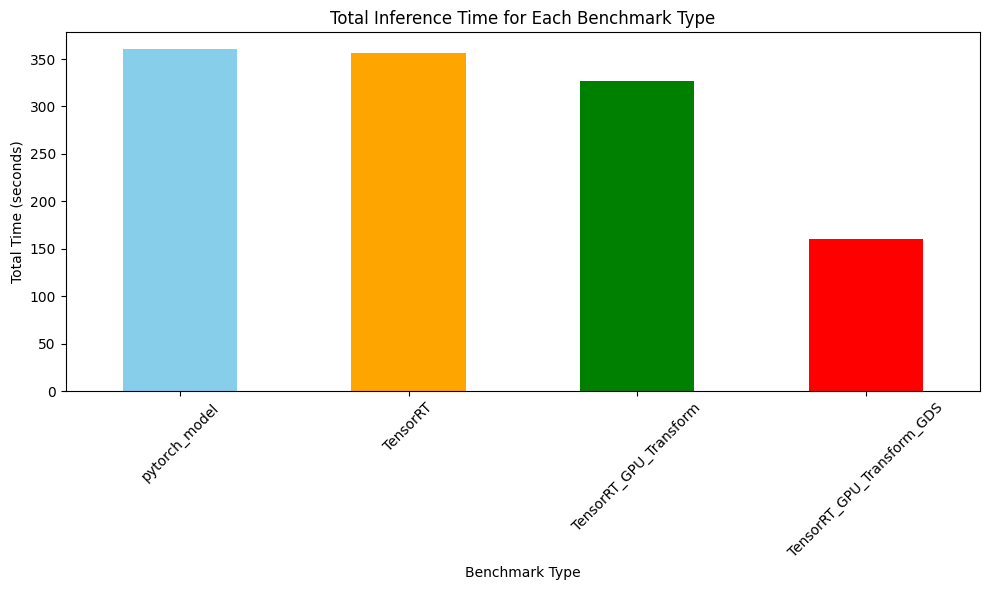

In [11]:
total_time.index = ["pytorch_model", "TensorRT", "TensorRT_GPU_Transform", "TensorRT_GPU_Transform_GDS"]

plt.figure(figsize=(10, 6))
total_time.plot(kind="bar", color=["skyblue", "orange", "green", "red"])
plt.title("Total Inference Time for Each Benchmark Type")
plt.xlabel("Benchmark Type")
plt.ylabel("Total Time (seconds)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Compare the Original model and the most optimized model

If we plot all the scatter points comparing the original model to the most optimized model, it becomes evident that larger files benefit significantly more from our optimizations.

With the file size increasing, the inference time of the original model increases significantly, while the inference time of the most optimized model does not show obvious increase. This indicates that our approach is particularly effective for handling larger datasets.

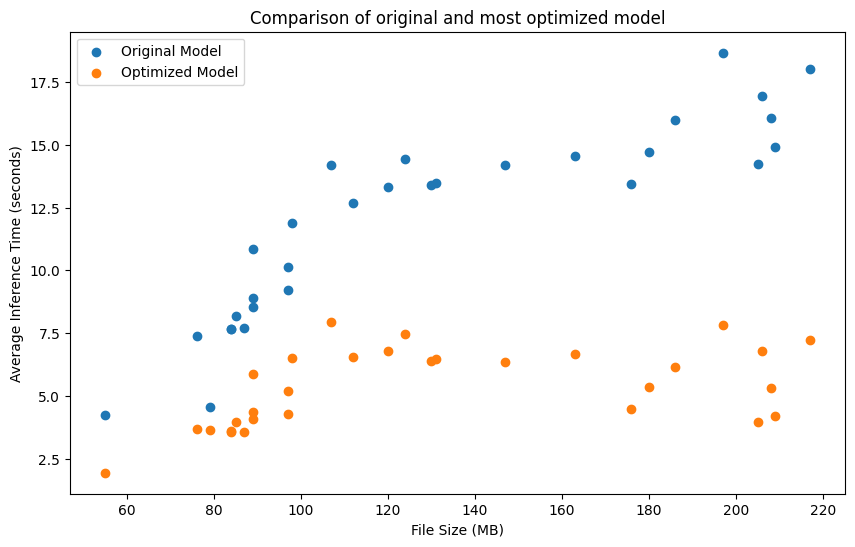

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(all_df["file_size"], all_df["original_time"], label="Original Model")
plt.scatter(all_df["file_size"], all_df["trt_gds_gpu_transforms_time"], label="Optimized Model")
plt.xlabel("File Size (MB)")
plt.ylabel("Average Inference Time (seconds)")
plt.title("Comparison of original and most optimized model")
plt.legend()
plt.show()